# Driver safety estimation

In [94]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

## Supress scientific notation
pd.options.display.float_format = '{:.4f}'.format

In [95]:
## read data from csv
dfRaw = pd.read_csv("dataset.csv",index_col='DriverId')
dfRaw['ts']= pd.to_datetime(dfRaw.ts)
print('Size of dataset: {}'.format(len(dfRaw)))

Size of dataset: 899611


In [96]:
dfRaw.head(10)

EventName  Latitude  Longitude  Speed km/h  \
DriverId                                                    
0            Timed Event   34.1866  -118.0881     64.0000   
0         Distance Event   34.1861  -118.0892     53.0000   
0         Distance Event   34.1864  -118.0896     34.0000   
0         Distance Event   34.1875  -118.0889     33.0000   
0         Distance Event   34.1887  -118.0865     32.0000   
0         Distance Event   34.1882  -118.0873     47.0000   
0         Distance Event   34.1894  -118.0864     24.0000   
0            Timed Event   34.1888  -118.0861     35.0000   
0         Distance Event   34.1891  -118.0851     43.0000   
0         Distance Event   34.1901  -118.0839     48.0000   

                              ts  
DriverId                          
0        2017-11-01 00:00:02.430  
0        2017-11-01 00:00:05.600  
0        2017-11-01 00:00:13.640  
0        2017-11-01 00:00:26.070  
0        2017-11-01 00:00:35.090  
0        2017-11-01 00:00:46.330  
0        2017-11-01 00:00:55.320  
0        2017-11-01 00:01:02.770  
0        2017-11-01 00:01:06.610  
0        2017-11-01 00:01:14.530

In [97]:
maxTime = dfRaw['ts'].max()
minTime = dfRaw['ts'].min()
print("Events were taken between " + str(minTime.date()) + " and " + str(maxTime.date()))

Events were taken between 2017-10-31 and 2017-11-18


In [98]:
driverCount = len(dfRaw.index.value_counts())
print("Number of drivers: {}".format(driverCount))

Number of drivers: 89


In [99]:
eventsPerDriver = dfRaw.groupby('DriverId').agg({"EventName":"count"}).add_suffix('_count')
print("Mean number of events per driver {:0.1f}".format(np.mean(eventsPerDriver).values[0]))
eventsPerDriver.head(10)

Mean number of events per driver 10108.0


EventName_count
DriverId                 
0                   17345
1                   20694
2                   11945
3                     819
4                    6811
5                   24152
6                    5700
7                   12693
8                   19606
9                    3928

Text(0,0.5,'Number of drivers')

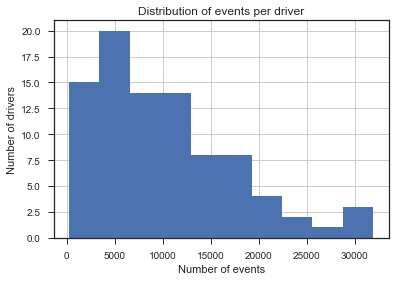

In [100]:
eventsPerDriver.sort_values(by='EventName_count',ascending = False,inplace = True)

eventsHist = eventsPerDriver['EventName_count'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

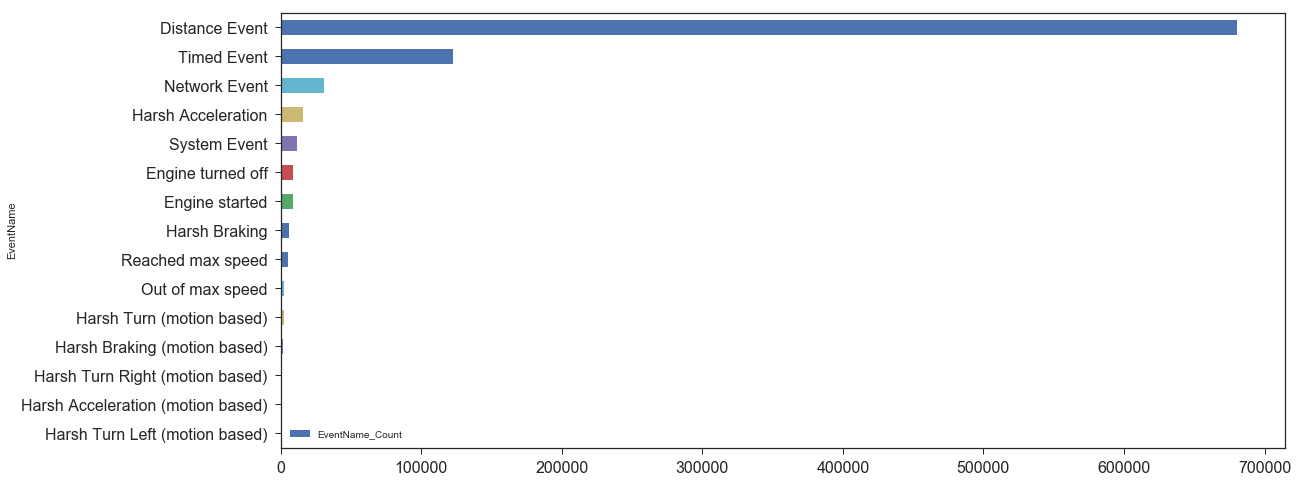

In [101]:
dfReasonHist = dfRaw.groupby(['EventName'])[['EventName']].agg('count').add_suffix('_Count').reset_index().sort_values('EventName_Count',ascending=True)
dfReasonHist.plot.barh('EventName','EventName_Count',figsize=(18,8),fontsize = 16)

In [102]:
events = [event for event in dfRaw.EventName if event not in ['Distance Event','Timed Event','Network Event','System Event']]
newCount = len(dfRaw[dfRaw['EventName'].isin(events)])
print("# of events before removing Distance Event, Timed Event, Network Event: {}, After removing: {}.\nReduction of {:0.2f} events. Current number of events: {}".format(len(dfRaw),newCount,(len(dfRaw) - newCount)/len(dfRaw),newCount))

# of events before removing Distance Event, Timed Event, Network Event: 899611, After removing: 54242.
Reduction of 0.94 events. Current number of events: 54242


In [103]:
RELEVANT_EVENTS = ['Harsh Acceleration', 'Reached max speed', 'Out of max speed',
       'Harsh Braking', 'Harsh Turn (motion based)',
       'Harsh Braking (motion based)', 'Harsh Acceleration (motion based)',
       'Harsh Turn Left (motion based)', 'Harsh Turn Right (motion based)']


def prepData(dfRaw, minRecordsPerSubscriber = 50):
    dfRaw.reset_index(inplace=True)
    print("*** Starting data prep. Length:",len(dfRaw),"***")
  
    
    #Remove NAs
    dfRaw = dfRaw.dropna()
    print("Removed NAs. Length:",len(dfRaw))

    ## Filter out unwanted events
    df = dfRaw[dfRaw.EventName.isin(RELEVANT_EVENTS)]
    print("Keeping only events that are relevant for modeling. Length:",len(df))
    
    
    ## Filter out users with too few samples
    eventCountPerDriver = df.groupby('DriverId')['DriverId'].agg('count')
    driversWithManyRecords = eventCountPerDriver[eventCountPerDriver > minRecordsPerSubscriber]
    driversWithManyRecords.keys()
    df = df[df.DriverId.isin(driversWithManyRecords.keys())]
    print("Filtering users with too few samples. Length:",len(df))

    print("*** Done. ***")
    return(df)

df = prepData(dfRaw)

df.head()

*** Starting data prep. Length: 899611 ***
Removed NAs. Length: 899611
Keeping only events that are relevant for modeling. Length: 36468
Filtering users with too few samples. Length: 36262
*** Done. ***


DriverId           EventName  Latitude  Longitude  Speed km/h  \
41          0  Harsh Acceleration   34.1899  -118.0828     49.0000   
112         0   Reached max speed   34.1802  -118.1362    115.0000   
130         0    Out of max speed   34.1689  -118.1440     69.0000   
149         0       Harsh Braking   34.1591  -118.1414     98.0000   
186         0   Reached max speed   34.1375  -118.1473    122.0000   

                         ts  
41  2017-11-01 14:30:12.120  
112 2017-11-01 14:35:26.830  
130 2017-11-01 14:36:19.710  
149 2017-11-01 14:38:01.930  
186 2017-11-01 14:39:59.440

Text(0,0.5,'Number of drivers')

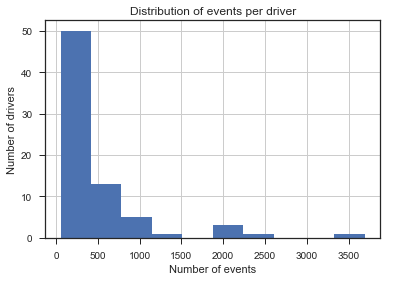

In [104]:
relevantEventsPerSubscriber = df.groupby('DriverId').agg({"EventName":"count"}).sort_values(by='EventName',ascending = False)

eventsHist = relevantEventsPerSubscriber['EventName'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

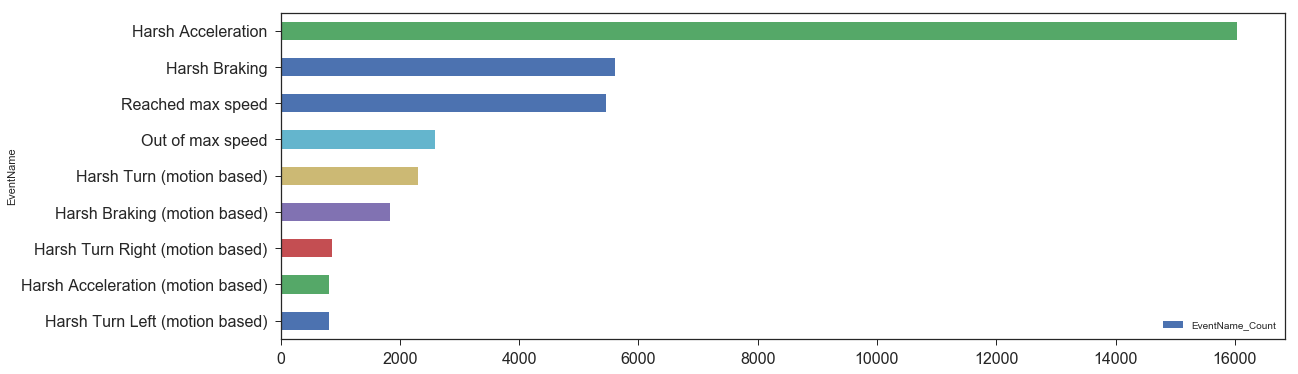

In [105]:
dfReasonHist = df.groupby('EventName')[['EventName']].agg('count').add_suffix('_Count').reset_index().sort_values('EventName_Count',ascending=True)
dfReasonHist.plot.barh('EventName','EventName_Count',figsize=(18,6),fontsize = 16)

In [106]:
## Calculate haversine distance (https://en.wikipedia.org/wiki/Haversine_formula)
## Code taken (and modified) from here: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def total_distance(oneDriver):
    dist = haversine(oneDriver.Longitude.shift(1), oneDriver.Latitude.shift(1),
                 oneDriver.loc[1:, 'Longitude'], oneDriver.loc[1:, 'Latitude'])
    return np.sum(dist)


## Calculate the overall distance made by each driver
def calculate_overall_distance_travelled(dfRaw):
    dfDistancePerDriver = dfRaw.groupby('DriverId').apply(total_distance).reset_index(name='Distance')    
    return dfDistancePerDriver

distancePerDriver = calculate_overall_distance_travelled(dfRaw)
distancePerDriver.head(10)

DriverId  Distance
0         0 3761.7317
1         1 4317.0790
2         2 2509.1244
3         3  491.1896
4         4 1409.9199
5         5 5087.1414
6         6 1271.6811
7         7 2598.3032
8         8 4227.1878
9         9  906.6564

In [109]:
## Transform the events data frame to a features data frame (column for each type of relevant event)
def create_feature_set(df, distancePerDriver):
    dfEventAggByDriver = df.groupby(['DriverId','EventName'])[['EventName']].agg('count').add_suffix('_Count').reset_index()

    
    ## Pivot events into columns
    dfEventMatrix = dfEventAggByDriver.pivot(index='DriverId',columns='EventName', values='EventName_Count').add_prefix('F_').fillna(0).reset_index()
    dfEventMatrix = dfEventMatrix.merge(distancePerDriver, how = 'inner',on='DriverId')
    dfEventMatrix.set_index('DriverId', inplace=True)
    
    featureCols = [col for col in dfEventMatrix if col.startswith('F_')]
    dfEventMatrix[featureCols] = dfEventMatrix[featureCols].div(dfEventMatrix['Distance'], axis=0)

    dfFeatureSet = dfEventMatrix[featureCols]
    
    return dfFeatureSet

features = create_feature_set(df,distancePerDriver)

In [110]:
features.head()

F_Harsh Acceleration  F_Harsh Acceleration (motion based)  \
DriverId                                                              
0                       0.0747                               0.0003   
1                       0.0243                               0.0002   
2                       0.0769                               0.0044   
4                       0.0468                               0.0000   
5                       0.0627                               0.0012   

          F_Harsh Braking  F_Harsh Braking (motion based)  \
DriverId                                                    
0                  0.0231                          0.0122   
1                  0.0102                          0.0021   
2                  0.0275                          0.0120   
4                  0.0589                          0.0206   
5                  0.0147                          0.0049   

          F_Harsh Turn (motion based)  F_Harsh Turn Left (motion based)  \
DriverId                                                                  
0                              0.0069                            0.0066   
1                              0.0000                            0.0025   
2                              0.0052                            0.0012   
4                              0.0369                            0.0262   
5                              0.0177                            0.0035   

          F_Harsh Turn Right (motion based)  F_Out of max speed  \
DriverId                                                          
0                                    0.0040              0.0117   
1                                    0.0019              0.0153   
2                                    0.0000              0.0060   
4                                    0.0078              0.0099   
5                                    0.0092              0.0120   

          F_Reached max speed  
DriverId                       
0                      0.0154  
1                      0.0174  
2                      0.0104  
4                      0.0092  
5                      0.0204

In [112]:
features = features.rename(columns={'F_Harsh Acceleration (motion based)': "Harsh Acceleration",
                                    'F_Harsh Braking (motion based)': "Harsh Braking",
                                   'F_Harsh Turn (motion based)':"Harsh Turning"},copy =False)
    
# select only motion based
features = features[['Harsh Acceleration','Harsh Braking','Harsh Turning']]

features.head()

Harsh Acceleration  Harsh Braking  Harsh Turning
DriverId                                                  
0                     0.0003         0.0122         0.0069
1                     0.0002         0.0021         0.0000
2                     0.0044         0.0120         0.0052
4                     0.0000         0.0206         0.0369
5                     0.0012         0.0049         0.0177

### Scatterplot matrix of features

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


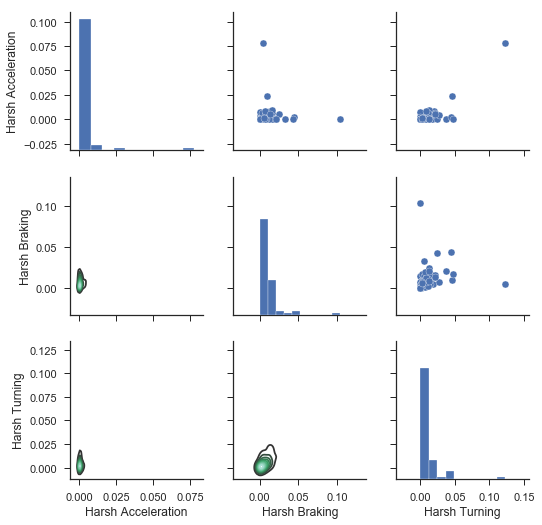

In [113]:
import seaborn as sns
sns.set(style="ticks",font_scale=1.1)
g = sns.PairGrid(features)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")

In [65]:
features.loc[features['Harsh Turning'].idxmax(), ]

Harsh Acceleration   0.0778
Harsh Braking        0.0045
Harsh Turning        0.1226
Name: 51, dtype: float64

In [114]:
import scipy.stats as st

def transform_to_normal(x,min_max_transform = False):
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    valueGreaterThanZero = np.where(x<=0,0,1)
    positives = x[valueGreaterThanZero == 1]
    if(len(positives)> 0):
        xt[valueGreaterThanZero == 1],_ = st.boxcox(positives+1)
    if min_max_transform:
        xt = (xt - np.min(xt)) / (np.max(xt)-np.min(xt))
    return xt

transFeatures = features.apply(lambda x: (transform_to_normal(x,min_max_transform = True)))
transFeatures.head()

Harsh Acceleration  Harsh Braking  Harsh Turning
DriverId                                                  
0                     0.0386         0.5650         0.3484
1                     0.0337         0.1329         0.0000
2                     0.4766         0.5569         0.2748
4                     0.0000         0.7523         0.8953
5                     0.1601         0.2851         0.6641

### Scatter plot matrix of transformed features

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


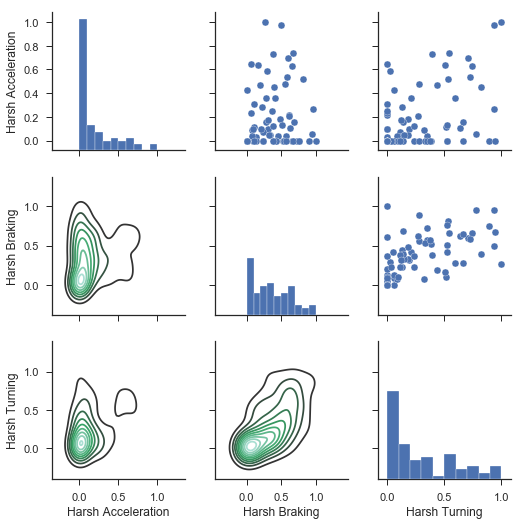

In [115]:
g = sns.PairGrid(transFeatures)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")

In [116]:
### remove outliers
import seaborn as sns
sns.set(style="ticks")

def replace_outliers_with_limit(x, stdFactor = 2.5, normalize = False):
    print(x.name)
    x = x.values
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    xt = transform_to_normal(x)

    xMean, xStd = np.mean(xt), np.std(xt)
    outliers = np.where(xt > xMean + stdFactor*xStd)[0]
    inliers = np.where(xt <= xMean + stdFactor*xStd)[0]
    if len(outliers) > 0:
        print("found outlier with factor: "+str(stdFactor)+" : "+str(outliers))
        xinline = x[inliers]
        maxInRange = np.max(xinline)
        print("replacing outliers {} with max={}".format(outliers,maxInRange))
        vals = x.copy()
        vals[outliers] = maxInRange
        x= pd.Series(vals)
    else:
        print("No outliers found")
    if normalize:
        #Normalize to [0,1]
        x = (x - np.min(x)) / (np.max(x)-np.min(x))
    return x

cleanFeatures = features.apply(lambda x: (replace_outliers_with_limit(x)))
cleanFeatures.head(6)


Harsh Acceleration
found outlier with factor: 2.5 : [15 44]
replacing outliers [15 44] with max=0.009031595984491887
Harsh Acceleration
found outlier with factor: 2.5 : [15 44]
replacing outliers [15 44] with max=0.009031595984491887
Harsh Braking
No outliers found
Harsh Turning
No outliers found


Harsh Acceleration  Harsh Braking  Harsh Turning
0              0.0003         0.0122         0.0069
1              0.0002         0.0021         0.0000
2              0.0044         0.0120         0.0052
3              0.0000         0.0206         0.0369
4              0.0012         0.0049         0.0177
5              0.0008         0.0142         0.0165

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


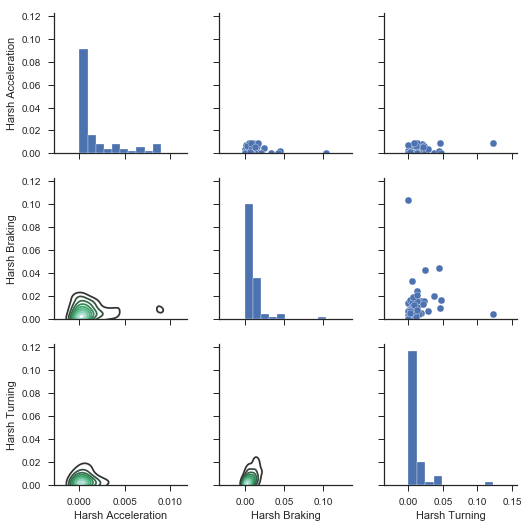

In [117]:
g = sns.PairGrid(cleanFeatures)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.set(ylim=((cleanFeatures.min().min()),(cleanFeatures.max().max())))

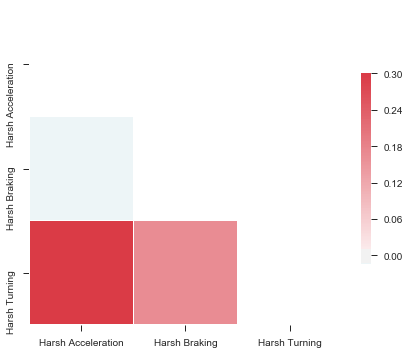

In [118]:
corr = cleanFeatures.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [71]:
## Pre step: Normalize features
minPerFeature = cleanFeatures.min()
maxPerFeature = cleanFeatures.max()

print("Min and Max values per column before normalization")
for col in range(0,len(cleanFeatures.columns)):
    print("{} range:[{},{}]".format(cleanFeatures.columns[col],minPerFeature[col],maxPerFeature[col]))

normalizedFeatures = (cleanFeatures-cleanFeatures.min())/(cleanFeatures.max()-cleanFeatures.min())
normalizedFeatures.head()


## Standardize features after box-cox as well.
transFeaturesScaled = (transFeatures - transFeatures.mean())/transFeatures.std()
print("")
print("Mean and STD before standardization")
for col in range(0,len(transFeatures.columns)):
    print("{} range:[{},{}]".format(transFeatures.columns[col],transFeatures.mean()[col],transFeatures.std()[col]))


normalizedFeatures.head()

Min and Max values per column before normalization
Harsh Acceleration range:[0.0,0.009031595984491887]
Harsh Braking range:[0.0,0.10340548522686539]
Harsh Turning range:[0.0,0.12259498755008752]

Mean and STD before standardization
Harsh Acceleration range:[0.18775905276289825,0.25588420026047654]
Harsh Braking range:[0.3556351512504195,0.276056089678018]
Harsh Turning range:[0.2865774139188881,0.29888576889340224]


Harsh Acceleration  Harsh Braking  Harsh Turning
0              0.0294         0.1183         0.0564
1              0.0256         0.0202         0.0000
2              0.4854         0.1156         0.0423
3              0.0000         0.1989         0.3008
4              0.1306         0.0475         0.1443

In [72]:
## LOF - Local Outlier Filter
from sklearn.neighbors import LocalOutlierFactor

X = transFeaturesScaled.values

clf = LocalOutlierFactor(n_neighbors=5)
isOutlier = clf.fit_predict(X)

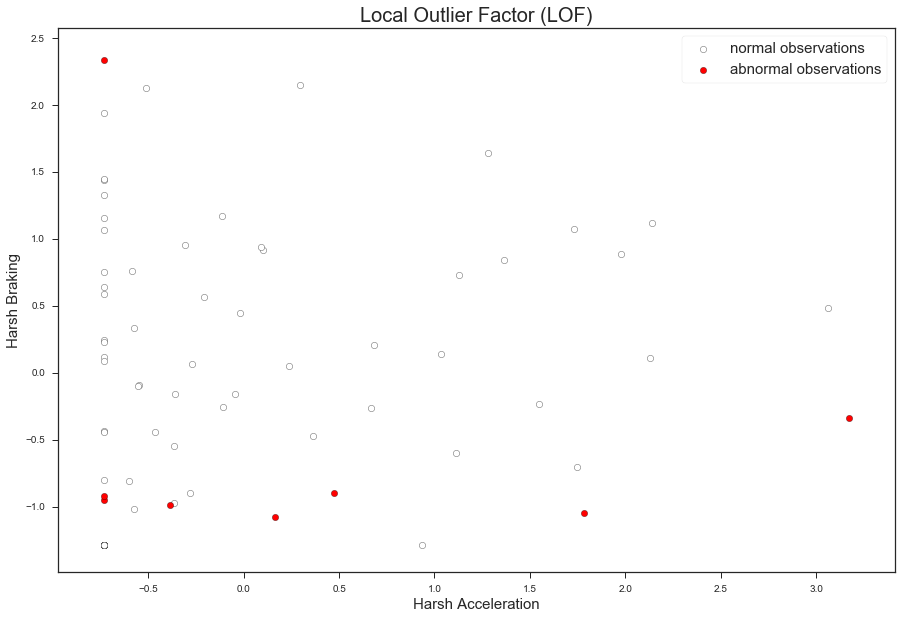

In [73]:
plt.title("Local Outlier Factor (LOF)",fontsize=20)


a = plt.scatter(X[isOutlier==1, 0], X[isOutlier==1, 1], c='white',
                edgecolor='k', s=40)
b = plt.scatter(X[isOutlier==-1, 0], X[isOutlier==-1, 1], c='red',
                edgecolor='k', s=40)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.xlabel(normalizedFeatures.columns[0],fontsize = 15)
plt.ylabel(normalizedFeatures.columns[1],fontsize = 15)
#plt.xlim((-0.01,1.01))
#plt.ylim((-0.01, 1.01))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper right",prop={'size': 15},frameon = True)
plt.show()

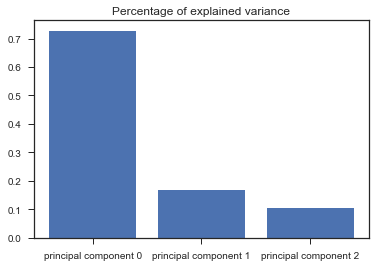

Pricipal components explained variance ratio: [0.7275472  0.16648689 0.10596592].


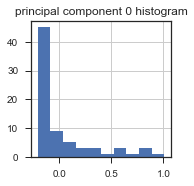

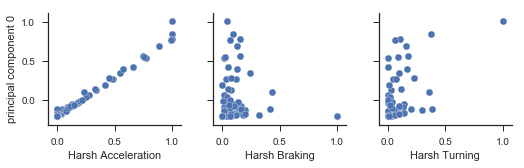

In [131]:
### PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

principalComponents = pca.fit_transform(normalizedFeatures)
column_names = ['principal component {}'.format(i) for i in range(normalizedFeatures.shape[1])]


plt.bar(x = column_names,height = pca.explained_variance_ratio_)
plt.title("Percentage of explained variance")
plt.show()

print("Pricipal components explained variance ratio: {}.".format(pca.explained_variance_ratio_))


principalDf = pd.DataFrame(data = principalComponents
             , columns = column_names)

import matplotlib.pyplot as plt
df = normalizedFeatures
fig = plt.gcf()
fig.set_size_inches(15,10)


## Show correlation matrix of the original features and the first principal component
pcAndOriginal = pd.concat([principalDf.iloc[:,0].reset_index(drop=True), normalizedFeatures], axis=1)
sns.set(style="ticks")
histplot = pcAndOriginal['principal component 0'].hist(figsize = (2.5,2.5))
histplot.set_title("principal component 0 histogram")
sns.pairplot(pcAndOriginal,y_vars=['principal component 0'],
                  x_vars=['Harsh Acceleration', 'Harsh Braking', 'Harsh Turning'])


In [133]:
import scipy.stats as st


def fit_distribution_params(series):
    print("Extracting distribution parameters for feature: " + series.name + " (" + str(len(series)) + ' values)')
    xPositive = series[series>0]
  
    probs = np.zeros(len(series))
    if(len(xPositive)>0):
        params = st.expon.fit(xPositive)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        #print('params = {}, {}, {}.'.format(arg,loc,scale))
        return arg, loc, scale

def calculate_score_for_series(x, fittedParams,verbose = False):
    
    print("Calculating scores for feature: "+ x.name)
    xPositive = x[x>0]
  
    probs = np.zeros(len(x))
    if(len(xPositive)>0):
        arg = fittedParams[x.name]['arg']
        loc = fittedParams[x.name]['loc']
        scale = fittedParams[x.name]['scale']
        probs[x>0] = st.expon.cdf(xPositive, loc=loc, scale=scale, *arg)
        if verbose:
            probs_df = pd.DataFrame({'Event value':x.values.tolist(),'Event probability':probs},index = None)
            probs_df = probs_df.sort_values(by = 'Event value')
            print(probs_df)
    return probs

## Store each fitted distribution parameters for later use
fittedParams = {}
for col in normalizedFeatures.columns:
    arg,loc,scale = fit_distribution_params(normalizedFeatures[col])
    fittedParams[col] = {}
    fittedParams[col]['arg'] = arg
    fittedParams[col]['loc'] = loc
    fittedParams[col]['scale'] = scale
import json
print('Fitted parameters:')
print(json.dumps(fittedParams, indent=2))

##Commulative distribution/density function
perFeatureScores = normalizedFeatures.apply(calculate_score_for_series,args=(fittedParams,False),axis=0).add_suffix("_CDF")

perFeatureScores.head()

Extracting distribution parameters for feature: Harsh Acceleration (74 values)
Extracting distribution parameters for feature: Harsh Braking (74 values)
Extracting distribution parameters for feature: Harsh Turning (74 values)
Fitted parameters:
{
  "Harsh Acceleration": {
    "arg": [],
    "loc": 0.02564752667369235,
    "scale": 0.3035523938874951
  },
  "Harsh Braking": {
    "arg": [],
    "loc": 0.008563681894357935,
    "scale": 0.10105576180418932
  },
  "Harsh Turning": {
    "arg": [],
    "loc": 0.0037259420919605983,
    "scale": 0.09982577201370954
  }
}
Calculating scores for feature: Harsh Acceleration
Calculating scores for feature: Harsh Acceleration
Calculating scores for feature: Harsh Braking
Calculating scores for feature: Harsh Turning


Harsh Acceleration_CDF  Harsh Braking_CDF  Harsh Turning_CDF
0                  0.0124             0.6623             0.4099
1                  0.0000             0.1084             0.0000
2                  0.7801             0.6533             0.3203
3                  0.0000             0.8480             0.9490
4                  0.2923             0.3199             0.7554

Harsh Acceleration
sse: 88.81292779966475
Harsh Braking
sse: 24.760400326313338
Harsh Turning
sse: 98.53717270817495


Text(0,0.5,'Number of drivers')

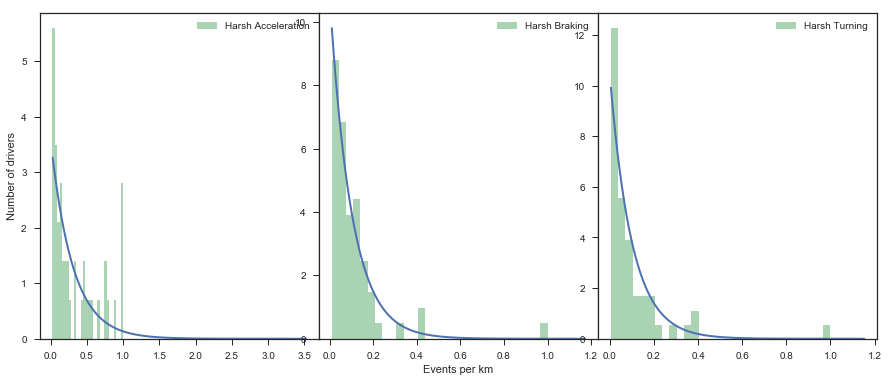

In [134]:
## Plot each fitted distribution

import matplotlib.pyplot as plt
import scipy.stats as st

DIST = st.expon

def create_pdf(dist, params, size=10000):

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99999, loc=loc, scale=scale)
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

## fit exponential distribution
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i=0
for col in normalizedFeatures:
    print(col)
    feature = normalizedFeatures[col]
    x = feature.values[feature.values > 0] # only fit positive values to keep the distribution tighter
   
    params = DIST.fit(x)

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
   
    #Plot
    pdfForPlot = create_pdf(DIST,params)
    pdfForPlot.plot(lw=2, label='PDF',ax=axs[i])
    
    #Plot
    feature[feature.values >0].plot(kind='hist', bins=30, density=True, alpha=0.5, label=feature.name, legend=True,ax=axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    ## Calculate SSE
    yhist, xhist = np.histogram(x, bins=60, density=True)
    xhist = (xhist + np.roll(xhist, -1))[:-1] / 2.0
    histPdf = DIST.pdf(xhist, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(yhist - histPdf, 2.0))
    print("sse:",sse)
    i+=1
axs[1].set_xlabel('Events per km')
axs[0].set_ylabel('Number of drivers')

    

In [77]:
def calculate_joint_score(perFeatureScores):
    driverScores = perFeatureScores
    featureCols = [col for col in driverScores if col.startswith('Harsh')]
    driverScores['metric'] = (driverScores[featureCols].sum(axis = 1) / 3.0)
    driverScores = driverScores.sort_values('metric')
    driverScores['rank'] = (driverScores.metric.rank(method="min")-1)/((len(perFeatureScores)-1)*1.0)
    return driverScores

driverScores = calculate_joint_score(perFeatureScores)

In [78]:
from sklearn.linear_model import LinearRegression

def get_linear_model(perFeatureScores):
    driverScores = calculate_joint_score(perFeatureScores)
    reg = LinearRegression()
    x = driverScores['metric'].values.reshape(-1, 1)
    y = driverScores['rank'].values.reshape(-1, 1)
    reg.fit(x,y)
    return reg
    

def get_rank(regModel,metric):
    rank = regModel.predict(metric)
    rank = np.asscalar(np.where(rank > 1,1,rank))
    rank = np.asscalar(np.where(rank < 0,0,rank))
    return rank
    
regModel = get_linear_model(perFeatureScores)
sampleRank = get_rank(regModel,0.5)
sampleRank

0.6946498430580719

In [79]:
## Top 10 safest drivers?
driverScores.head(10)

Harsh Acceleration_CDF  Harsh Braking_CDF  Harsh Turning_CDF  metric  \
32                  0.0000             0.0000             0.0000  0.0000   
29                  0.0000             0.0000             0.0000  0.0000   
70                  0.0000             0.0000             0.0000  0.0000   
68                  0.0000             0.0000             0.0000  0.0000   
67                  0.0000             0.0000             0.0000  0.0000   
6                   0.0000             0.0000             0.0000  0.0000   
27                  0.0000             0.0000             0.0000  0.0000   
25                  0.0000             0.0000             0.0000  0.0000   
51                  0.0000             0.0000             0.0000  0.0000   
20                  0.0000             0.0000             0.0000  0.0000   

     rank  
32 0.0000  
29 0.0000  
70 0.0000  
68 0.0000  
67 0.0000  
6  0.0000  
27 0.0000  
25 0.0000  
51 0.0000  
20 0.0000

In [80]:
## top 10 most risky drivers?
driverScores.tail(10)

Harsh Acceleration_CDF  Harsh Braking_CDF  Harsh Turning_CDF  metric  \
39                  0.0598             0.9813             0.8590  0.6334   
59                  0.7543             0.4610             0.8924  0.7026   
44                  0.9596             0.2898             1.0000  0.7498   
42                  0.8187             0.8948             0.6243  0.7793   
72                  0.8374             0.6871             0.8154  0.7800   
48                  0.9596             0.7658             0.6326  0.7860   
7                   0.9421             0.7005             0.7953  0.8127   
37                  0.4887             0.9844             0.9724  0.8152   
16                  0.9075             0.7541             0.8275  0.8297   
15                  0.9596             0.5761             0.9755  0.8371   

     rank  
39 0.8767  
59 0.8904  
44 0.9041  
42 0.9178  
72 0.9315  
48 0.9452  
7  0.9589  
37 0.9726  
16 0.9863  
15 1.0000

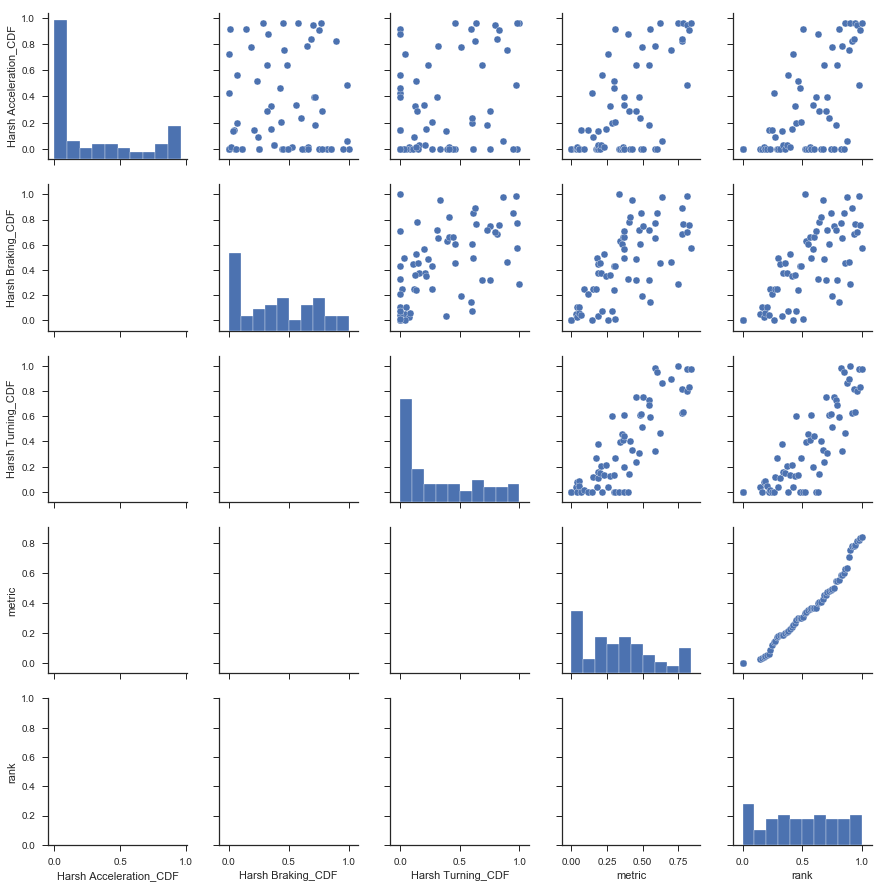

In [81]:
import seaborn as sns
sns.set(style="ticks")
g = sns.PairGrid(driverScores)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_diag(plt.hist, edgecolor="w")

In [89]:
safeDriver = [{'Harsh Acceleration':0.005,
                       'Harsh Braking':0.005,
                       'Harsh Turning':0.005}]

riskyDriver = [{'Harsh Acceleration':0.2,
                       'Harsh Braking':0.16,
                       'Harsh Turning':0.28}]

safeDriverDf = pd.DataFrame(safeDriver,index = None)
riskyDriverDf = pd.DataFrame(riskyDriver,index = None)

print('****** Estimated safety scores ******')
def get_score_one_driver(driverDf,fittedParams,minPerFeature,maxPerFeature):

    normalized = (driverDf - minPerFeature) / (maxPerFeature - minPerFeature)
    scoreDF = pd.DataFrame()
    for col in normalized:
        scoreDF[col] = calculate_score_for_series(normalized[col],fittedParams,True)
    scoreDF = calculate_joint_score(scoreDF)
    return scoreDF


safeDriverWithMetric = get_score_one_driver(safeDriverDf, fittedParams,minPerFeature,maxPerFeature)
riskyDriverWithMetric = get_score_one_driver(riskyDriverDf, fittedParams,minPerFeature,maxPerFeature)

safeDriverMetric = safeDriverWithMetric['metric'].values[0]
riskyDriverMetric = riskyDriverWithMetric['metric'].values[0]


print('------')
print("Rank for safe driver = {}".format(get_rank(regModel,safeDriverMetric)))
print("Metric for safe driver = {}".format(safeDriverMetric))
print('------')
print("Rank for risky driver = {}".format(get_rank(regModel,riskyDriverMetric)))
print("Metric for risky driver = {}".format(riskyDriverMetric))


****** Estimated safety scores ******
Calculating scores for feature: Harsh Acceleration
   Event probability  Event value
0             0.8244       0.5536
Calculating scores for feature: Harsh Braking
   Event probability  Event value
0             0.3255       0.0484
Calculating scores for feature: Harsh Turning
   Event probability  Event value
0             0.3101       0.0408
Calculating scores for feature: Harsh Acceleration
   Event probability  Event value
0             1.0000      22.1445
Calculating scores for feature: Harsh Braking
   Event probability  Event value
0             1.0000       1.5473
Calculating scores for feature: Harsh Turning
   Event probability  Event value
0             1.0000       2.2839
------
Rank for safe driver = 0.6785927595653235
Metric for safe driver = 0.486647447960139
------
Rank for risky driver = 1.0
Metric for risky driver = 0.9999999186733707
